In [1]:


# Set matplotlib backend
# This has to be done before other importa that might
# set it, but only if we're running in script mode
# rather than being imported.
# get_ipython().run_line_magic('matplotlib', 'inline')
import random
import os
import sys
import json
import datetime
import numpy as np
import skimage.io
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("./")
print(ROOT_DIR)
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
from mrcnn.model import log
import scipy.io as sio

from keras.applications.imagenet_utils import preprocess_input


# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
# DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR,"caries", "logs")
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
# Results directory
# Save submission files here
RESULTS_DIR = os.path.join(ROOT_DIR, "results/")
# print(COCO_WEIGHTS_PATH,DEFAULT_LOGS_DIR,RESULTS_DIR)
# exit(0)


# The dataset doesn't have a standard train/val split, so I picked
# a variety of images to surve as a validation set.
VAL_IMAGE_IDS = [
    "mdb058",
    "mdb111",
    "mdb179",
    "mdb213",
    "mdb241",
    "mdb274",
    "mdb125",
    "mdb010",
    "mdb030",
    "mdb097",
    "mdb145",
    "mdb188",
    "mdb222",
    "mdb314"
]




/home/ddh/Projects/DDH/Caries/Mask_RCNN/samples/Mammogram/Boston Meditech Group/Final/MaskRCNN


Using TensorFlow backend.


In [2]:
class MamoConfig(Config):
    """Configuration for training on the nucleus segmentation dataset."""
    # Give the configuration a recognizable name
    NAME = "mamo"
    GPU_COUNT = 2

    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # Background + Benign + Malignant

    # Number of training and validation steps per epoch
    STEPS_PER_EPOCH = (112 - len(VAL_IMAGE_IDS)) // IMAGES_PER_GPU
    VALIDATION_STEPS = max(1, len(VAL_IMAGE_IDS) // IMAGES_PER_GPU)

    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nucleus and BG
    DETECTION_MIN_CONFIDENCE = 0.35

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet101"

    # Input image resizing
    # Random crops of size 512x512
    IMAGE_RESIZE_MODE = "none"
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024
    IMAGE_MIN_SCALE = 2.0

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = ( 16, 32, 64, 128,256)
    #RPN_ANCHOR_SCALES = (2, 4, 8, 16)

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 1000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256

    # Image mean (RGB)
    # MEAN_PIXEL = np.array([43.53, 39.56, 48.22])
    MEAN_PIXEL = np.array([120, 120, 120])

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 512

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 3

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 3


config = MamoConfig()
config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.35
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      2
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [3]:
dataset_dir = '/home/ddh/Projects/DDH/Caries/Mask_RCNN/samples/Mammogram/Boston Meditech Group/Mask_rcnn_data/'  # Change file

In [4]:
class MamoDataset(utils.Dataset):

    def load_mamo(self, dataset_dir, subset):
        """Load a subset of the nuclei dataset.

        dataset_dir: Root directory of the dataset
        subset: Subset to load. Either the name of the sub-directory,
                such as stage1_train, stage1_test, ...etc. or, one of:
                * train: stage1_train excluding validation images
                * val: validation images from VAL_IMAGE_IDS
        """
        # Add classes. We have one class.
        # Naming the dataset nucleus, and the class nucleus
        self.add_class("mamo", 1, "Benign")
        self.add_class("mamo", 2, "Malignant")

        # Which subset?
        # "val": use hard-coded list above
        # "train": use data from stage1_train minus the hard-coded list above
        # else: use the data from the specified sub-directory
        assert subset in ["train", "val", "stage1_train", "stage1_test", "stage2_test"]
        subset_dir = "stage1_train" if subset in ["train", "val"] else subset
        dataset_dir = os.path.join(dataset_dir)
        if subset == "val":
            image_ids = VAL_IMAGE_IDS
        else:
            # Get image ids from directory names
            image_ids = next(os.walk(dataset_dir))[1]
            if subset == "train":
                image_ids = list(set(image_ids) - set(VAL_IMAGE_IDS))

        # Add images
        for image_id in image_ids:
            self.add_image(
                "mamo",
                image_id=image_id,
                path=os.path.join(dataset_dir, image_id, "Image/{}.png".format(image_id)))

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        # Get mask directory from image path
        mask_dir = os.path.join(os.path.dirname(os.path.dirname(info['path'])), "Mask")

        # Read mask files from .png image
        mask = []
        for f in next(os.walk(mask_dir))[2]:
            if f.endswith(".png"):
                m = skimage.io.imread(os.path.join(mask_dir, f)).astype(np.bool)
                mask.append(m)
        mask = np.stack(mask, axis=-1)
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID, we return an array of ones
        class_id_dir =  os.path.join(os.path.dirname(os.path.dirname(info['path'])), "Class_ids")
        for f in next(os.walk(class_id_dir))[2]:
            if f.endswith(".mat"):
                mat_contents = sio.loadmat(os.path.join(class_id_dir, f))

        class_ids = mat_contents["class_id"]
        class_ids = (np.array(class_ids, dtype=np.int32))
        class_ids = np.reshape(class_ids, (class_ids.shape[1],))
        class_ids = np.transpose(class_ids)
        return mask, class_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "mamo":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)



In [5]:
# Preparing Trainig dataset
dataset_train = MamoDataset()
dataset_train.load_mamo(dataset_dir, 'train')
dataset_train.prepare()

# Preparing Validation dataset
dataset_val = MamoDataset()
dataset_val.load_mamo(dataset_dir, 'val')
dataset_val.prepare()

In [6]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=DEFAULT_LOGS_DIR)

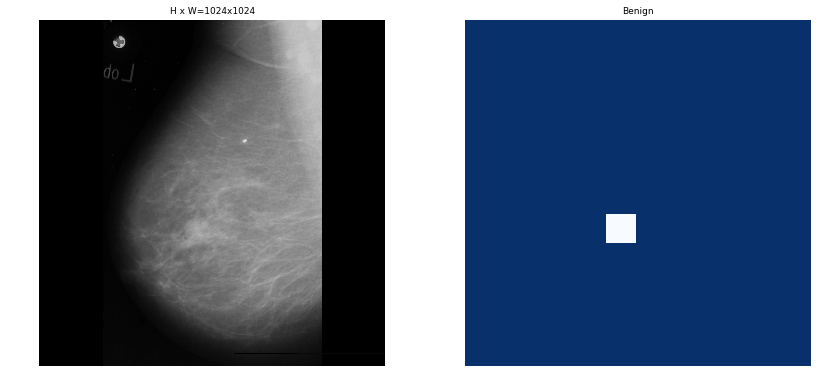

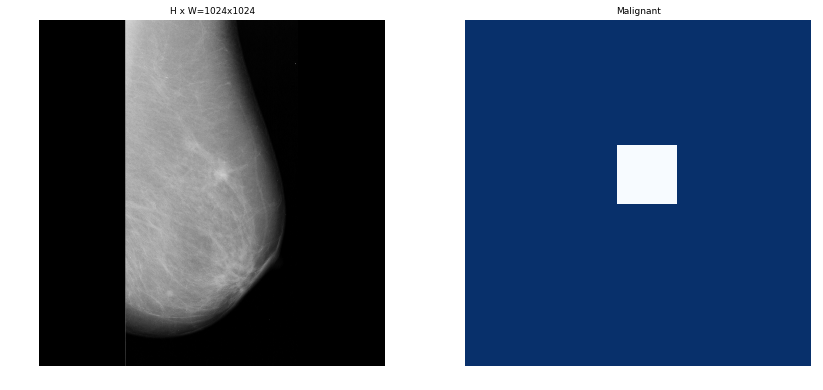

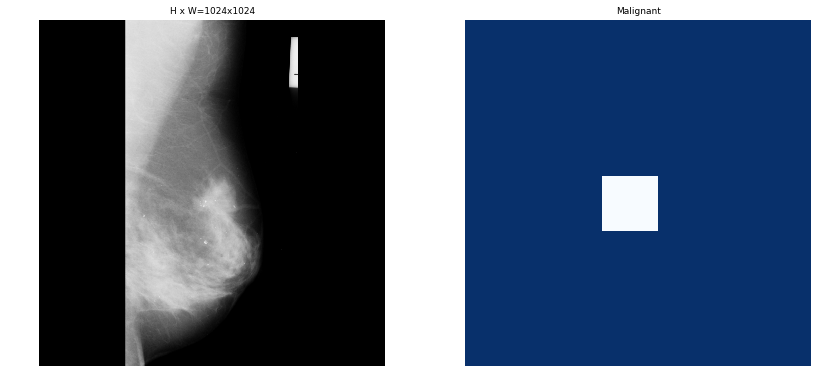

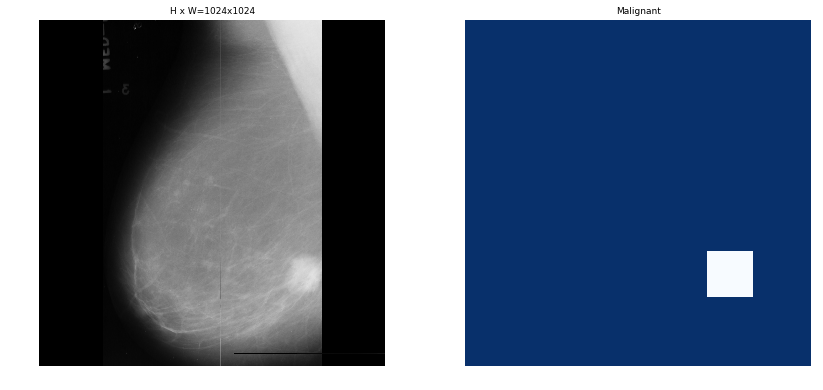

In [7]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=1)

In [8]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_WEIGHTS_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 60


In [9]:
from imgaug import augmenters as iaa

augmentation = iaa.SomeOf((0, 2), [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([iaa.Affine(rotate=90),
               iaa.Affine(rotate=180),
               iaa.Affine(rotate=270)]),
    iaa.Multiply((0.8, 1.5)),
    iaa.GaussianBlur(sigma=(0.0, 5.0))
])

Image Count: 98
Class Count: 3
  0. BG                                                
  1. Benign                                            
  2. Malignant                                         
original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  230.00000  uint8
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  237.00000  max:  534.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


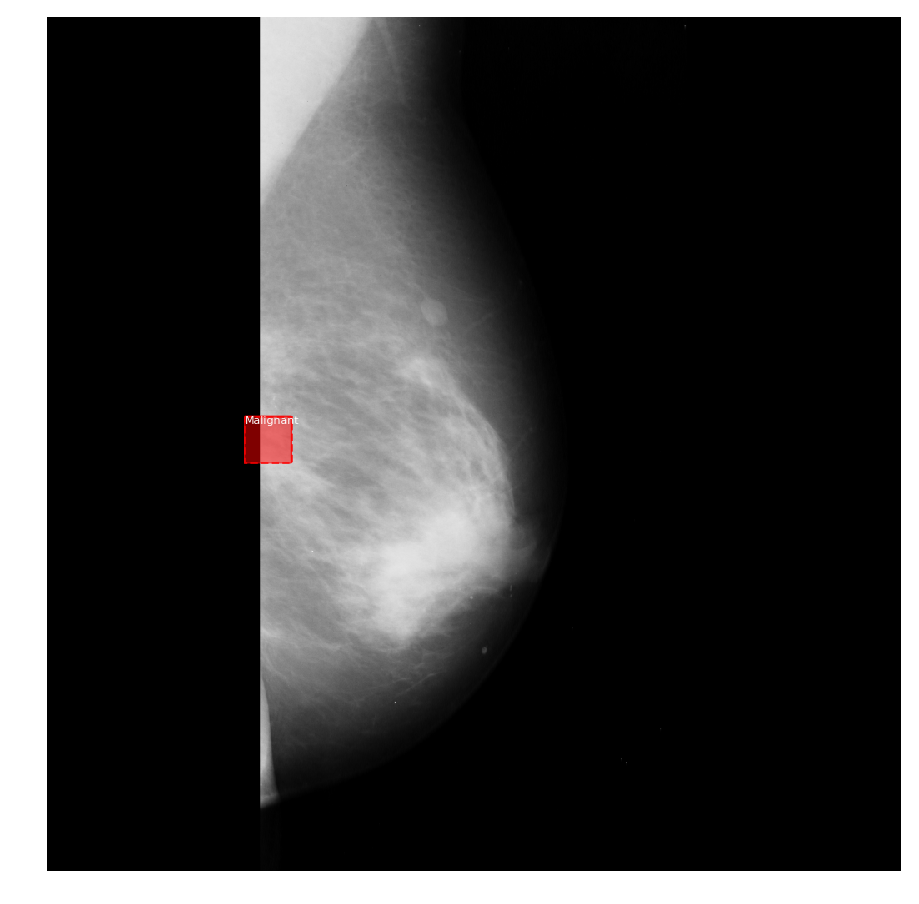

In [10]:
dataset = MamoDataset()
# The subset is the name of the sub-directory, such as stage1_train,
# stage1_test, ...etc. You can also use these special values:
#     train: loads stage1_train but excludes validation images
#     val: loads validation images from stage1_train. For a list
#          of validation images see nucleus.py
dataset.load_mamo(dataset_dir, subset="train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))




image_id = random.choice(dataset_train.image_ids)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)
class_name = dataset_train.class_names

# Display image and additional stats
# print("image_id ", image_id, dataset_train.image_reference(image_id))
# Display image and instances
log("original_image", image)
log("gt_class_id", class_ids)
log("gt_bbox", bbox)
log("gt_mask", mask)
visualize.display_instances((image), (bbox), (mask), class_ids, class_name, show_bbox=True)


In [11]:

import warnings

warnings.filterwarnings("ignore")

In [ ]:

model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=20,
            augmentation=augmentation,
            layers='all')

# In[ ]:



model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=40,
            augmentation=augmentation,
            layers='all')

# In[14]:



model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 100,
            epochs=60,
            augmentation=augmentation,
            layers='all')

In [12]:
class InferenceConfig(MamoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()
# Device to load the neural network on.
# Useful if you're training a model
# on the same
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# Only inference mode is supported right now
TEST_MODE = "inference"


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.35
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [13]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    fig.tight_layout()
    return ax

In [14]:
# Create model in inference mode
LOGS_DIR = os.path.join(ROOT_DIR, "logs")
import tensorflow as tf

with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)

In [15]:
# Or, load the last model you trained
weights_path = model.find_last()
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /home/ddh/Projects/DDH/Caries/Mask_RCNN/samples/Mammogram/Boston Meditech Group/Final/MaskRCNN/logs/mamo20181023T1906/mask_rcnn_mamo_0060.h5
Re-starting from epoch 60


In [16]:
data_path = '/home/ddh/Projects/DDH/Caries/Mask_RCNN/samples/Mammogram/Boston Meditech Group/Test_data/'
test_image = os.listdir(data_path)

image ID: mamo.mdb015 (3) mdb015
Original image shape:  [1024 1024    3]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  239.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  239.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   91.00000  max:  662.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool
AP @0.50:	 1.000
AP @0.55:	 1.000
AP @0.60:	 1.000
AP @0.65:	 1.000
AP @0.70:	 1.000
AP @0.75:	 1.000
AP @0.80:	 1.000
AP @0.85:	 1.000
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0.50-0.95:	 0.800


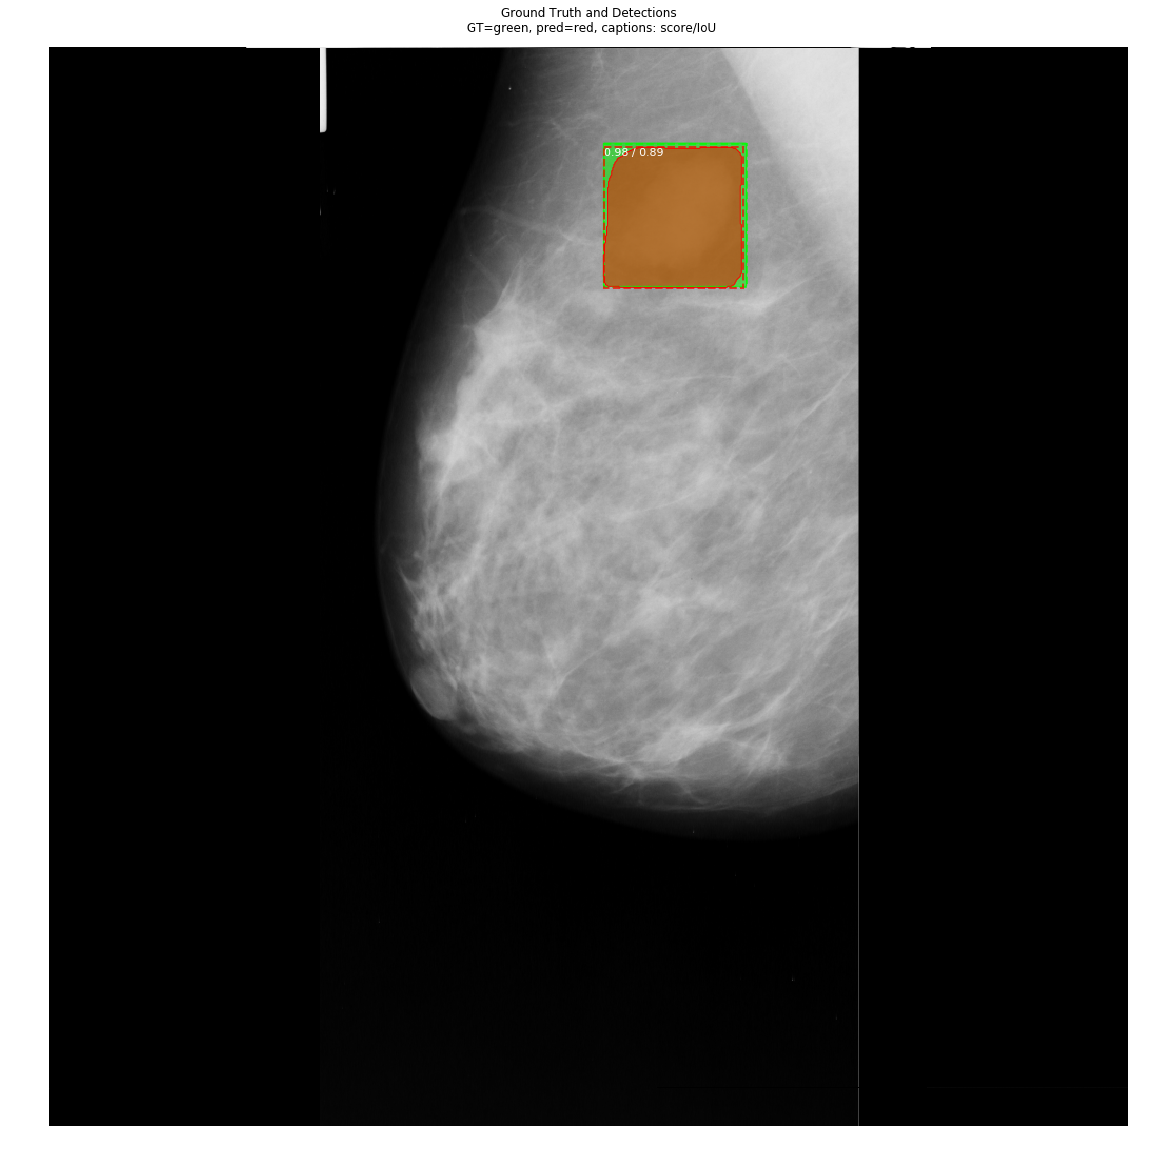

In [22]:
import random

image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id,
                                                                          use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis, ...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display result
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=True, show_mask=True,
    iou_threshold=0.5, score_threshold=0.5)

#visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, dataset.class_names)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  244.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -120.00000  max:  124.00000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
{'rois': array([[236, 439, 294, 498]], dtype=int32), 'class_ids': array([2], dtype=int32), 'scores': array([0.97927535], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [

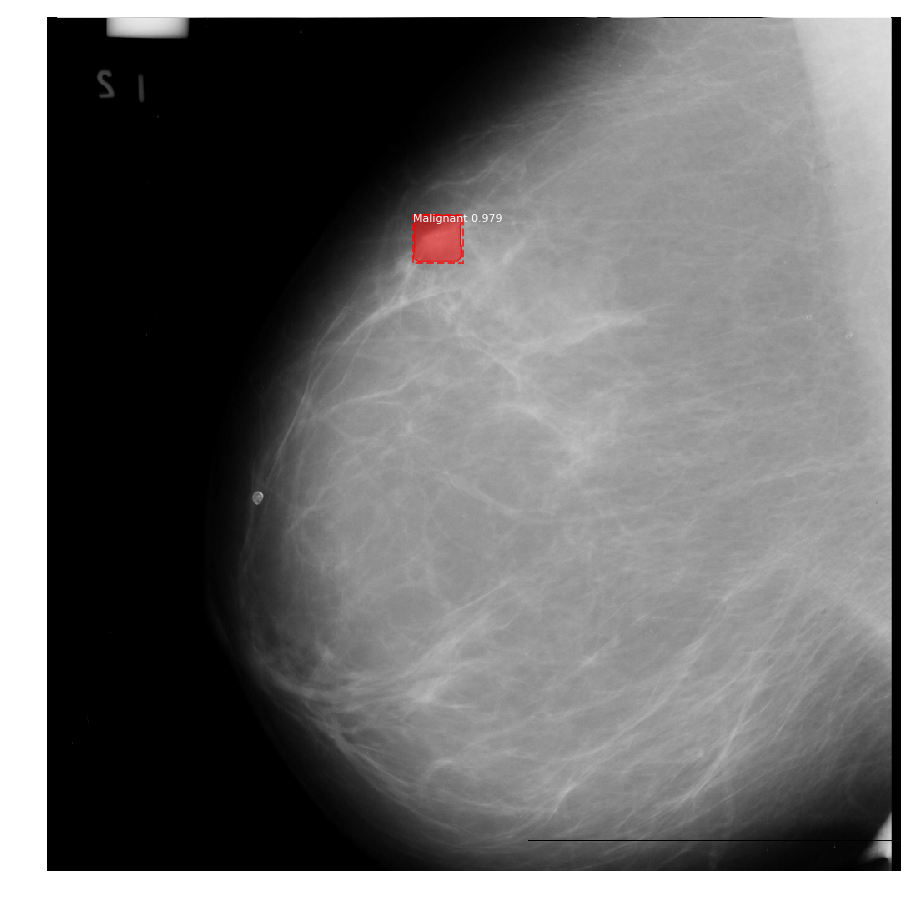

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  231.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -120.00000  max:  111.00000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
{'rois': array([[500, 399, 675, 576],
       [359, 407, 647, 728]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9564896 , 0.49884972], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
       

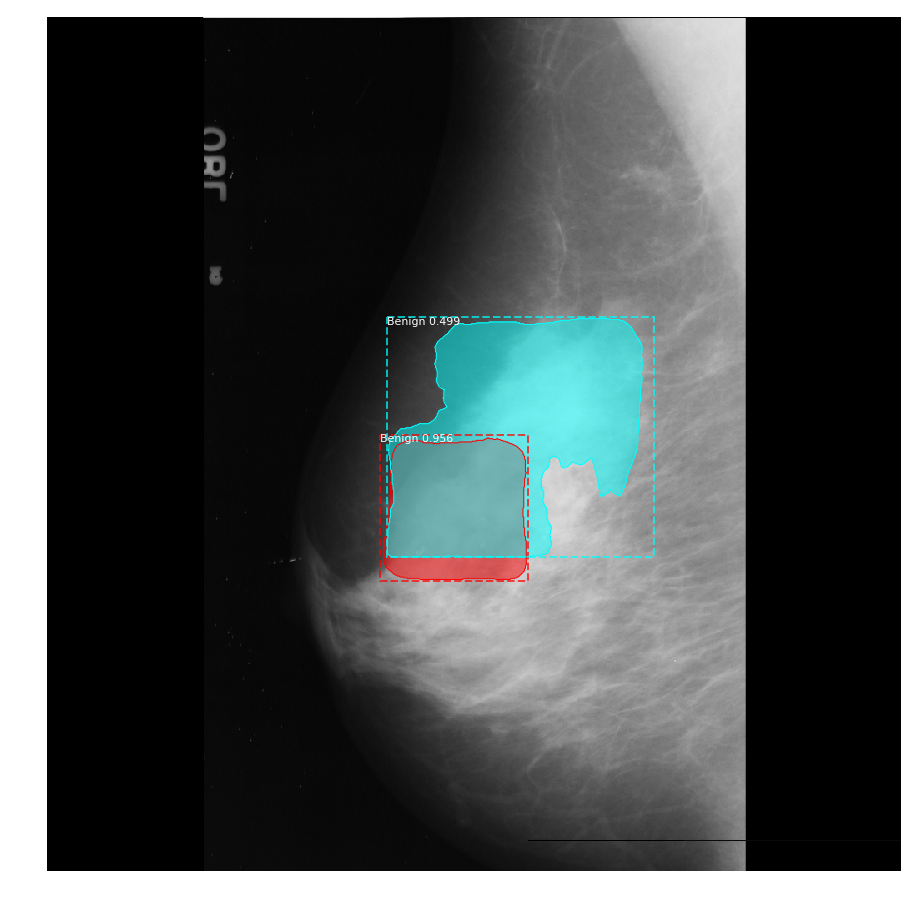

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  242.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -120.00000  max:  122.00000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
{'rois': array([[214, 520, 286, 590],
       [484, 506, 576, 595]], dtype=int32), 'class_ids': array([2, 1], dtype=int32), 'scores': array([0.99775785, 0.56383896], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
       

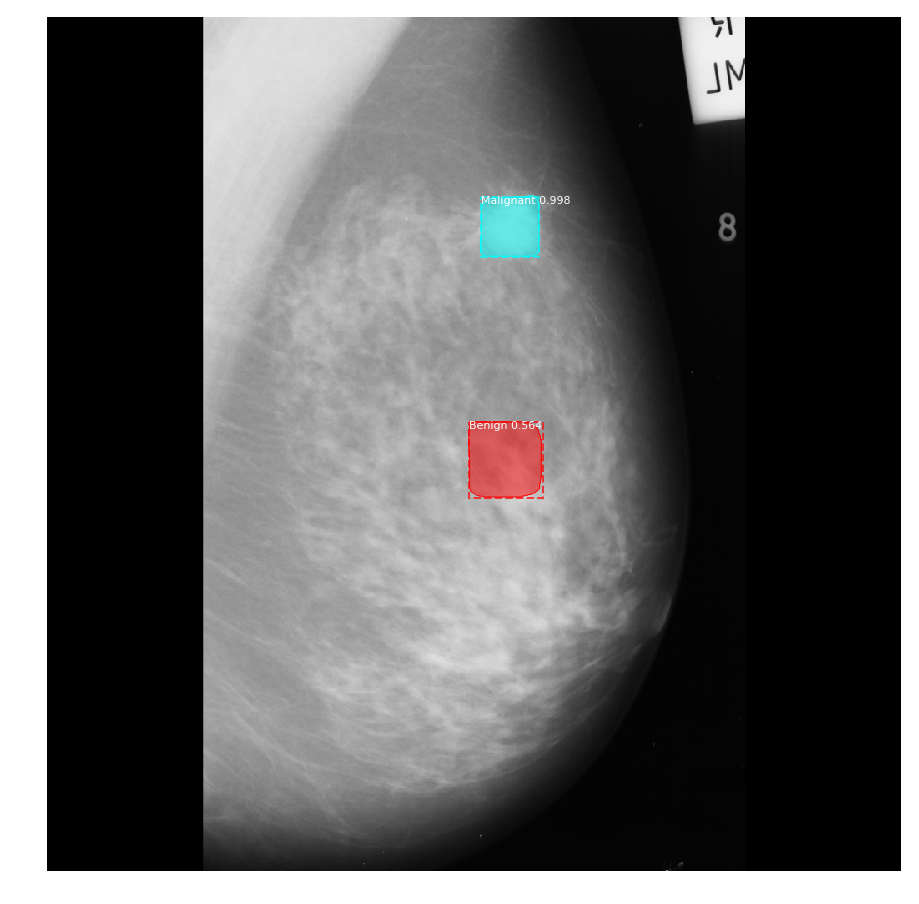

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  244.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -120.00000  max:  124.00000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
{'rois': array([[488, 440, 598, 548]], dtype=int32), 'class_ids': array([2], dtype=int32), 'scores': array([0.7537779], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [F

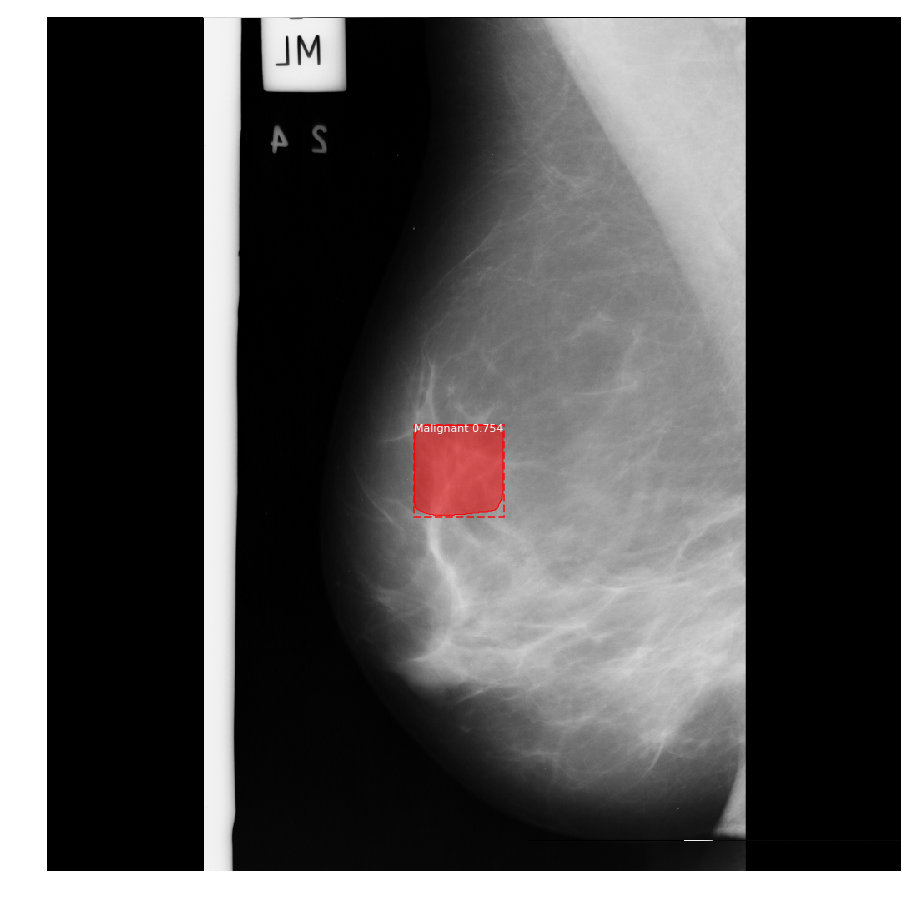

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  244.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -120.00000  max:  124.00000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}

*** No instances to display *** 



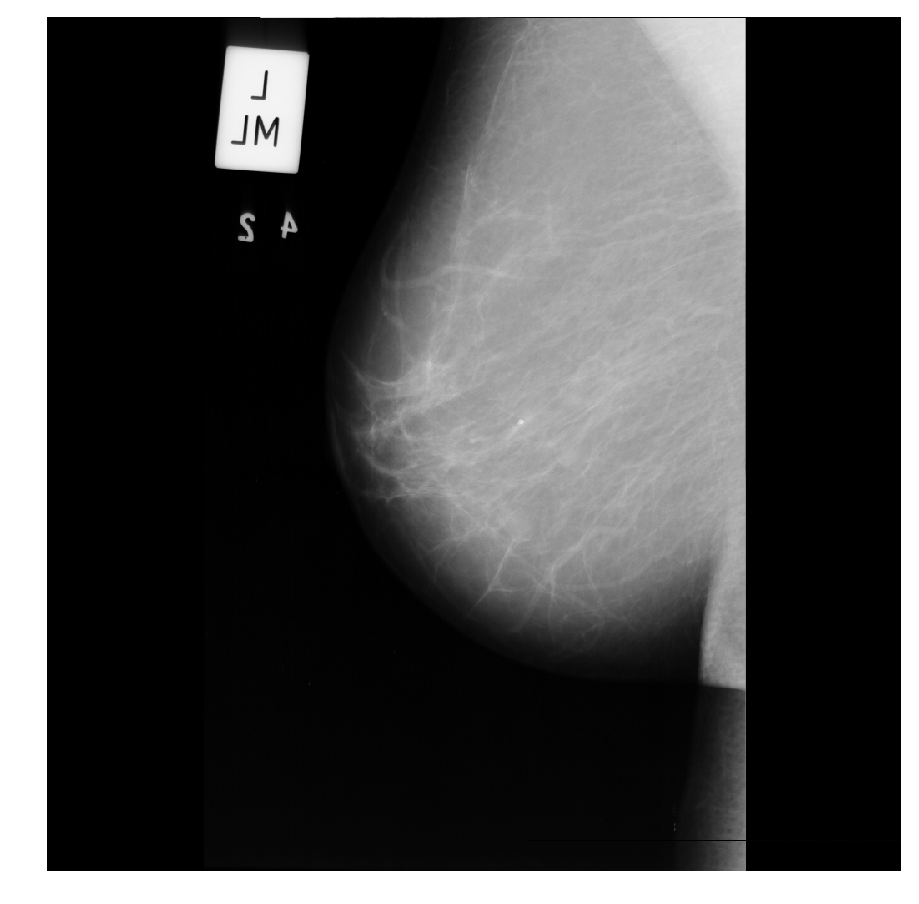

In [18]:
class_names = ['BG', 'Benign', 'Malignant']
for img in test_image:
    image1 = skimage.io.imread(data_path+img)

    image1 = skimage.color.gray2rgb(image1)
    result = model.detect([image1],verbose = 1)
    r = result[0]
    print(r)
    visualize.display_instances(image1,r['rois'], r['masks'], r['class_ids'],class_names, r['scores'])
